# Soft Attention MNIST

This is jupyter notebook for `Soft Attention` from paper [Show, Attend and Tell](https://arxiv.org/abs/1502.03044). 
<br>This Algorithm will be tested by `Modified MNIST dataset` Which is made by [Jongwon Park](https://github.com/jwpark116). <br>This modified MNIST dataset is good for verifying attention algorithm.
<br>You can download modified MNIST data from this link
<br>[Training dataset](https://www.dropbox.com/s/e7jxyulxx2anqyq/MNIST_data_train_re.mat?dl=0)  /  [Testing dataset](https://www.dropbox.com/s/fcw4754bavva9my/MNIST_data_test_re.mat?dl=0)

In [1]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data

mat_data_train = scipy.io.loadmat('MNIST_data_train_re.mat')
mat_data_test = scipy.io.loadmat('MNIST_data_test_re.mat')

train_x = mat_data_train['X_train']
train_y = mat_data_train['Y_train']

test_x = mat_data_test['X_test'][:9900, :]
test_y = mat_data_test['Y_test'][:9900, :]

validation_x = mat_data_test['X_test'][9900:, :]
validation_y = mat_data_test['Y_test'][9900:, :]

del mat_data_train
del mat_data_test

print("Train data shape: " + str(train_x.shape))
print("Train label shape: " + str(train_y.shape))
print("Test data shape: " + str(test_x.shape))
print("Test label shape: " + str(test_y.shape))
print("Validation data shape: " + str(validation_x.shape))
print("Validation label shape: " + str(validation_y.shape))

Train data shape: (55000, 112, 112)
Train label shape: (55000, 10)
Test data shape: (9900, 112, 112)
Test label shape: (9900, 10)
Validation data shape: (100, 112, 112)
Validation label shape: (100, 10)


## Parameters

In [3]:
# Parameters 
img_size = train_x.shape[1]
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = 'soft1'

# Numbers of sampling to test the code 
num_test_sample = 10

# labels: 0 - 9
num_label = 10

# Parameters for training
num_epoch = 10

learning_rate = 5e-4
epsilon = 1e-8

batch_size = 256

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

## Plotting Sample Image (Modified MNIST for Attention)

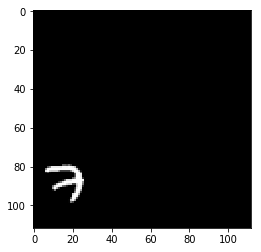

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shape: 112x112


In [4]:
# Plotting example image
img = train_x[0, :, :]

plt.imshow(img, cmap = 'gray')
plt.show()
print('Label: ' + str(train_y[0,:]))
print('Shape: ' + str(img_size) + 'x' + str(img_size))

## Functions for Convolutional Network

In [5]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## LSTM and Attention function

In [6]:
# Reset the graph
tf.reset_default_graph()

# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c) 
    h_t = tf.multiply(o, tf.tanh(C_t))
    
    return C_t, h_t # Cell state, Output

# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)     
    alpha = tf.nn.softmax(m_concat) 
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))]
    z_stack = tf.stack(z_list, axis = 2)
    z = tf.reduce_sum(z_stack, axis = 2)

    return alpha, z
    

## Network

In [7]:
# Network

# Input 
x_image  = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
y_target = tf.placeholder(tf.float32, shape=[None, num_label])

# Convolution variables
w_conv1 = weight_variable('W_conv1', [3, 3, 1, 64])
b_conv1 = bias_variable('b_conv1', [64])
w_conv2 = weight_variable('W_conv2', [3, 3, 64, 256])
b_conv2 = bias_variable('b_conv2', [256])
w_conv3 = weight_variable('W_conv3', [3, 3, 256, 512])
b_conv3 = bias_variable('b_conv3', [512])

conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 2) + b_conv1)
conv2 = tf.nn.relu(conv2d(conv1, w_conv2, 2) + b_conv2)
conv3 = tf.nn.relu(conv2d(conv2, w_conv3, 2) + b_conv3)

conv_size = conv3.get_shape()[1]
conv_flat = tf.reshape(conv3, [-1, conv_size*conv_size, 512])
conv_unstack = tf.unstack(conv_flat, axis = 1)

#LSTM Variables
Wf = weight_variable('Wf', [512 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [512 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [512 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [512 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [512, 1])
Wh = weight_variable('Wh', [lstm_size, 1])

rnn_batch_size = tf.shape(x_image)[0]

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)

#################################### Attention!!! ####################################
for i in range(step_size):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################

# Densely connect layer variables 
w_fc1 = weight_variable('w_fc1', [lstm_size, num_label])
b_fc1 = bias_variable('b_fc1', [num_label])

output = tf.matmul(rnn_out, w_fc1)+b_fc1

# Training 
Loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_target, logits = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:
Use the retry module or similar alternatives.


## Create Session

In [8]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Save and Restore

In [9]:
# Load the file if the saved file exists
saver = tf.train.Saver()
if Load_model == True:
    checkpoint = tf.train.get_checkpoint_state("saved_networks/")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")

INFO:tensorflow:Restoring parameters from saved_networks/soft1
Successfully loaded: saved_networks/soft1


## Training

In [10]:
# Training

if Is_train == True:
    train_data_num = train_x.shape[0]

    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[1]],:]
            else:
                batch_index = [j, j + train_data_num-1]

                batch_x_train = train_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
                batch_y_train = train_y[random_idx[batch_index[0]:batch_index[-1]],:]

            # Make image as fractions for attention
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 1))
            validation_batch = np.reshape(validation_x, (validation_x.shape[0], img_size, img_size, 1))
            
            # Training
            optimizer.run(feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = sess.run(Cost, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = sess.run(accuracy, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            val_acc = sess.run(accuracy, feed_dict = {x_image: validation_batch, y_target: validation_y})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        saver.save(sess, 'saved_networks/' + save_name)
        print('Model is saved!!!')

## Testing

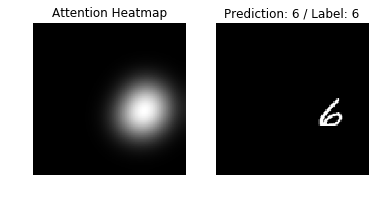

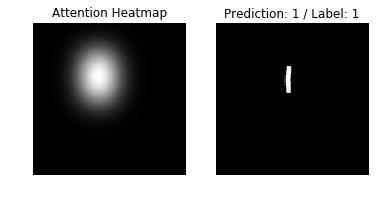

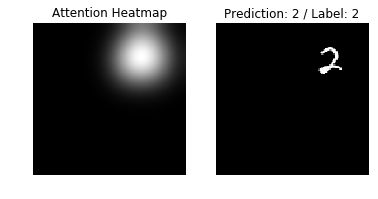

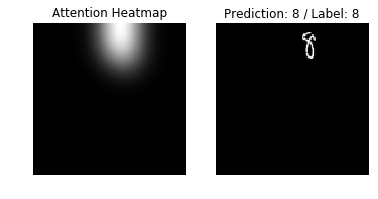

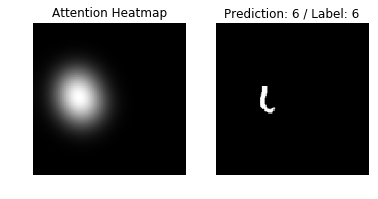

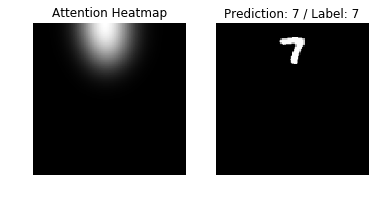

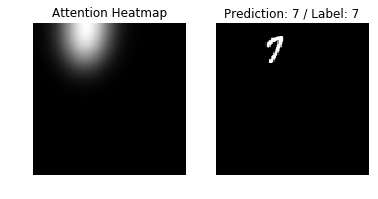

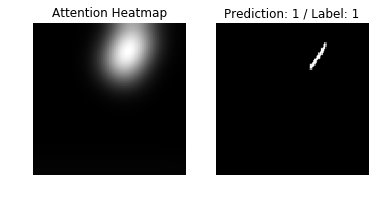

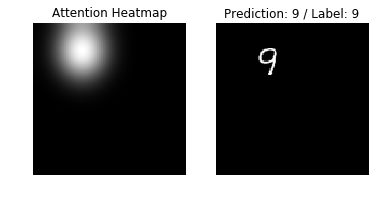

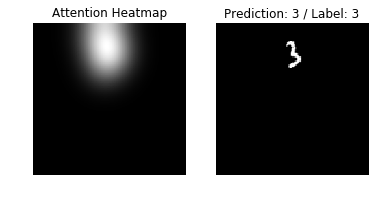

Sample Accuracy: 1.0


In [11]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 1])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,1]))
    test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))